<a href="https://colab.research.google.com/github/guptajaya181/dog-breed-prediction/blob/main/Dog_breed_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Project-NIIT/dog_breed_classification'

In [ ]:
!ls '/content/drive/MyDrive/Project-NIIT/dog_breed_classification'

labels.csv  sample_submission.csv  test  train


### Importing all the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.layers import BatchNormalization,Activation
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
from PIL import Image

In [ ]:
tf.test.gpu_device_name()   # checking if gpu is enabled or not

'/device:GPU:0'

In [ ]:
Image_size = 256     
No_of_class = 120

In [ ]:
train_dir = path + '/train'    # training images path
test_dir = path + '/test'      # testing images path

**Loading the dataset**

In [ ]:
df = pd.read_csv(path+'/labels.csv')   # loading the csv file which contains the labels and id of the dog breeds

In [ ]:
df.shape     # checking the shape of the dataset

(10222, 2)

In [ ]:
df.head()    #looking the first few datasets first few datasets

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,ffd3f636f7f379c51ba3648a9ff8254f,scottish_deerhound
freq,1,126


**Creating a dictionary**

Creating a dictionary where the 'key' is the name of the breed of the dog and the 'value' of it is the count/frequency of the breed.

In [ ]:
count = list(df['breed'].value_counts())
lab = list(df['breed'])
breed_count = dict()
breed_count = dict(zip(lab,count))
breed_count

{'affenpinscher': 82,
 'african_hunting_dog': 85,
 'airedale': 67,
 'appenzeller': 78,
 'australian_terrier': 82,
 'basenji': 110,
 'basset': 82,
 'bedlington_terrier': 95,
 'bernese_mountain_dog': 66,
 'black-and-tan_coonhound': 92,
 'bloodhound': 75,
 'bluetick': 66,
 'border_collie': 79,
 'border_terrier': 76,
 'borzoi': 111,
 'boston_bull': 88,
 'boxer': 73,
 'brittany_spaniel': 67,
 'bull_mastiff': 67,
 'cairn': 92,
 'chihuahua': 76,
 'collie': 78,
 'dhole': 87,
 'dingo': 69,
 'doberman': 99,
 'english_setter': 72,
 'entlebucher': 75,
 'german_shepherd': 80,
 'giant_schnauzer': 71,
 'golden_retriever': 88,
 'greater_swiss_mountain_dog': 82,
 'groenendael': 88,
 'ibizan_hound': 91,
 'irish_setter': 69,
 'irish_terrier': 70,
 'irish_water_spaniel': 83,
 'kelpie': 79,
 'komondor': 72,
 'kuvasz': 82,
 'labrador_retriever': 91,
 'lakeland_terrier': 73,
 'leonberg': 69,
 'malamute': 78,
 'malinois': 75,
 'maltese_dog': 75,
 'mexican_hairless': 71,
 'miniature_schnauzer': 80,
 'norfolk_t

**Plotiing the frequency of each breed**

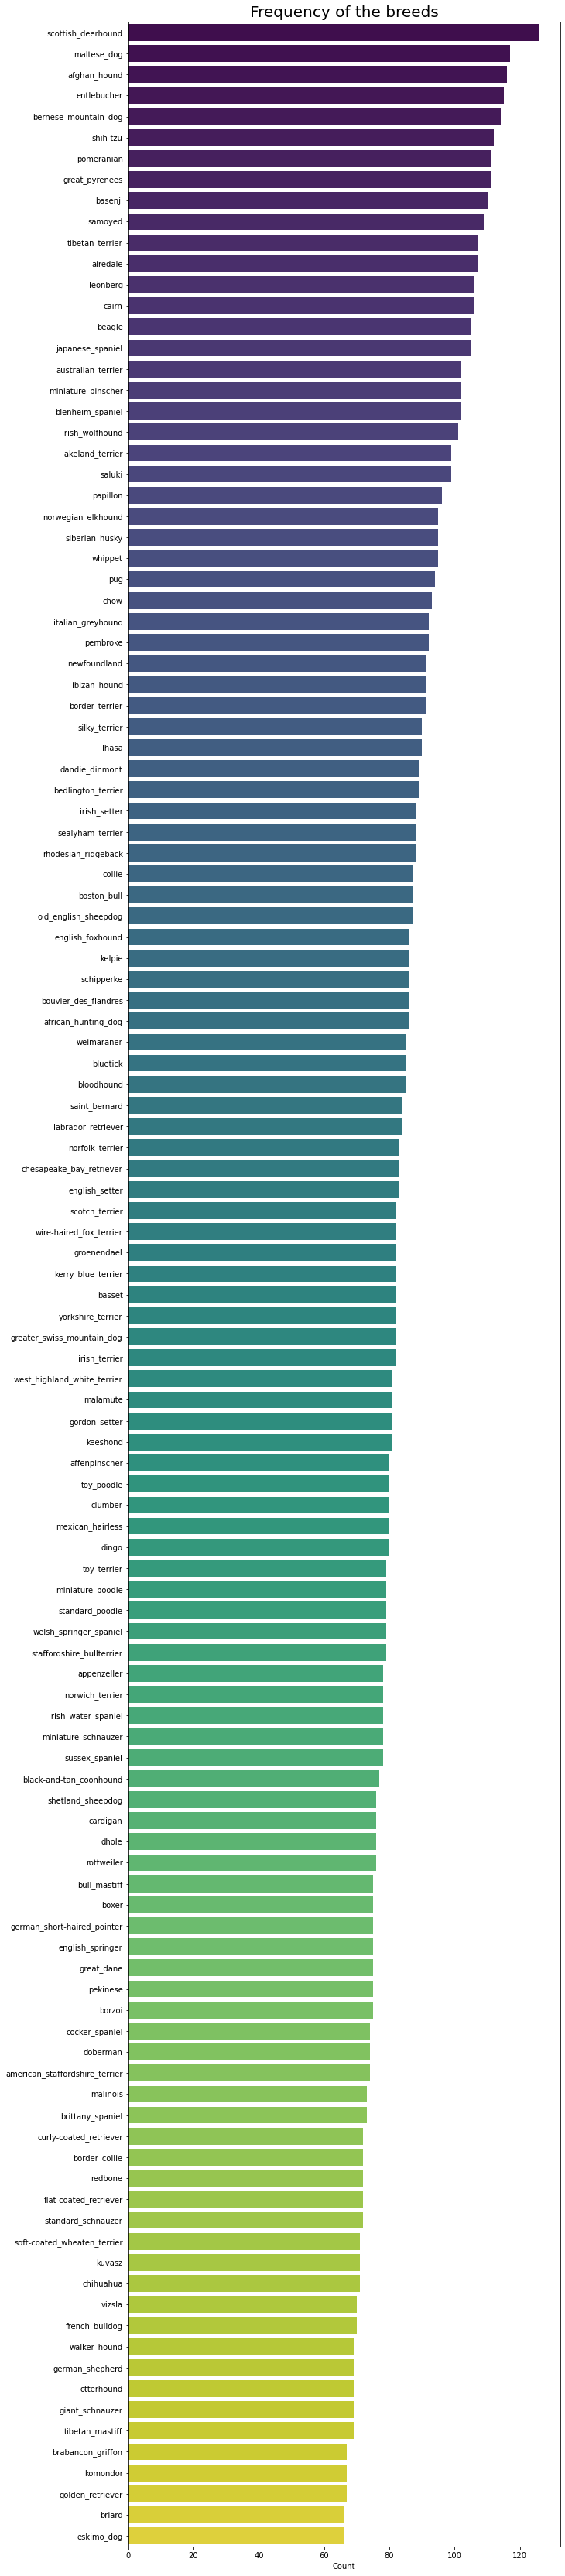

In [ ]:
plt.figure(figsize=(10,60))    # We create a canvas for the plot with the use of matplotlib library
sns.barplot(x=df['breed'].value_counts(),y=df['breed'].value_counts().index,palette='viridis')
plt.title('Frequency of the breeds',fontsize=20)
plt.xlabel('Count')
plt.savefig('Frequency_of_breeds.png')    # saving our graph in the same directory

### Feature selection

In [ ]:
X_train,X_test = train_test_split(df,test_size=0.3)    # Separating the training and testing part of the data by 30%

In [ ]:
X_train.shape   # checking the shape of training part

(7155, 2)

In [ ]:
X_train.head() 

,id,breed
9543,ef3dc6a3af2210c9cc59e2bbdc9e9ae1,west_highland_white_terrier
1850,2d96d7258d31f2e7430c91ce4cee2cb6,bull_mastiff
7295,b6c2bb1848f3063b69bf5e6b74e25582,brabancon_griffon
2249,38343daa2a67c48067f0f5e12a95aaef,greater_swiss_mountain_dog
6204,9c6f8f10027e0076ba75d10bfc3232a4,shih-tzu


In [ ]:
X_test.shape    # checking the shape of testing part

(3067, 2)

#### Creating Subfolders for each breed of the dog
In this function we will copy the images to a specific folder with each breed of dog into their subfolder. This is basically done so we can augment the data to avoid overfitting using ImageDataGenerator

In [ ]:
def Create_subfolder(src, dest, df):
    ar = np.asarray(df['breed'])
    df = np.asarray(df['id'])

    if not os.path.exists(dest):
        os.makedirs(dest)

    for i in tqdm(range(len(df))):
        file_x = src + "/" + df[i] + ".jpg"
        file_y = dest + ar[i] + "/" + df[i] + ".jpg"

        if not os.path.exists(dest+ ar[i] + "/"):
            os.makedirs(dest + ar[i] + "/")

            if not os.path.exists(path + "Train/"):
                os.makedirs(path + "Train/")

            file_y = path + "Train/" + ar[i] + ".jpg"
            shutil.copy(file_x, file_y)

        shutil.copy(file_x, file_y)

Once we copy the images we comment out the lines in order to avoid copying of the images again


In [ ]:
#copyFileSet(path+'total-images',path + "Train/", X_train)
#copyFileSet(path+'total-images',path + "Test/", X_test)

In [ ]:
print(len(os.listdir(train_dir)))
print(len(os.listdir(test_dir)))
# We see that all 120 classes of dog breeds are present in the train ans test files(which are originally the number of classes)

120
120


### Printing the images of the diffrent breed of dog

Here we use the PIL libraray to plot some images of the dog breeds

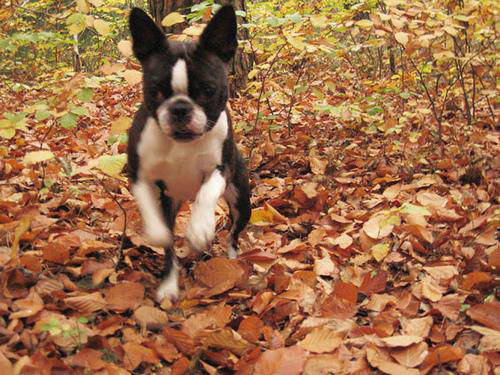

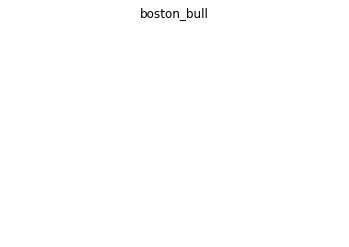

In [ ]:
plt.axis('off')
plt.title(df['breed'][0])
Image.open(train_dir+'/'+df['breed'][0]+'/'+df['id'][0]+'.jpg')

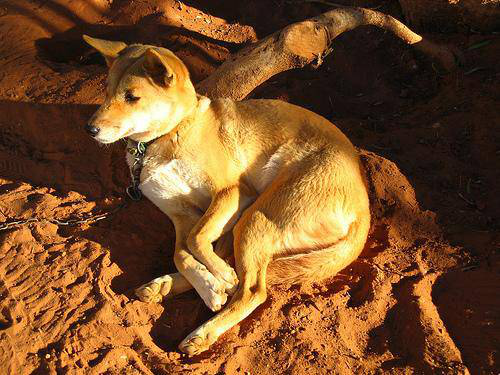

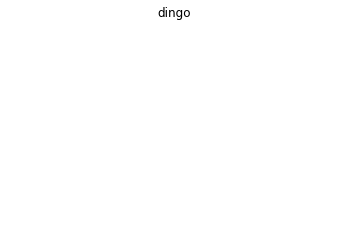

In [ ]:
plt.axis('off')
plt.title(df['breed'][1])
Image.open(train_dir+'/'+df['breed'][1]+'/'+df['id'][1]+'.jpg')

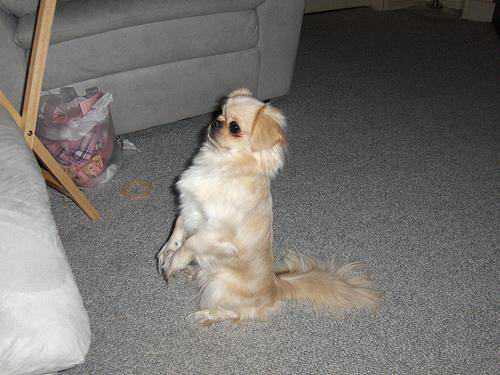

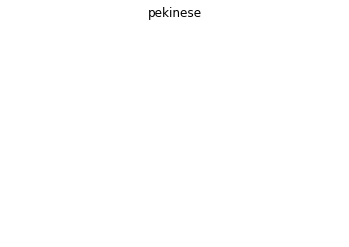

In [ ]:
plt.axis('off')
plt.title(df['breed'][2])
Image.open(train_dir+'/'+df['breed'][2]+'/'+df['id'][2]+'.jpg')

### ImageDataGenerator
This generates batches of tensor image data with real time data augmentation. This not only makes our model robust but also save up on the overhead memory.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                  zoom_range=0.25,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(train_dir,
                                             batch_size=50,
                                             target_size=(Image_size,Image_size),
                                             class_mode='categorical',
                                             shuffle=True)
test_gen = test_datagen.flow_from_directory(test_dir,
                                           batch_size=50,
                                           target_size=(Image_size,Image_size),
                                           class_mode='categorical',
                                           shuffle=True)

Found 7036 images belonging to 120 classes.
Found 2948 images belonging to 120 classes.


## CNN(Convolutional Nural Networks)

**Creating the neural network from scratch**

In [ ]:
early = EarlyStopping(monitor='val_accuracy',patience=3,verbose=1,restore_best_weights=True)   
# early stopping is used to monitor the testing accuracy in order to avoid overfitting

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,verbose=1)
# reduce learning rate means that if model performs and gives the same accuracy the model tries to reduce the learning rate so that it performs better

In [ ]:
step_size_tr = train_gen.n//train_gen.batch_size   # Step size of the training dataset
step_size_ts = test_gen.n//test_gen.batch_size     # Step size of the testing dataset


In [ ]:
def model_from_stratch():
  model = Sequential()   # creating the model base

  model.add(Conv2D(16, kernel_size=2 ,input_shape=(256,256,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=None))

  model.add(Conv2D(32,kernel_size=2,activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=None))

  model.add(Conv2D(64,kernel_size=2,activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=None))
  model.add(Dropout(0.5))

  model.add(Conv2D(128,kernel_size=2,activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=None))
  model.add(Dropout(0.5))

  model.add(GlobalAveragePooling2D())
  model.add(Dense(No_of_class,activation='softmax'))
  return model


**Description of the neural network**

We have created the neural network from scratch by adding 12 layers, using 4 convolution layers with max pooling layers and terminated with a fully connected layer with 120 nodes(number of classes).

In the fully connected layer we have used the softmax activation function whose range is from 0-1.


In [ ]:
model = model_from_stratch()

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

We have used **'adam' optimizer** here(could have used others like 'sgd' but 'adam' worked faster here)

We have also used **categorical_crossentropy** as our loss function which is used for multiclass image label prediction

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 255, 255, 16)      208       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 126, 32)      2080      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 64)       

In [ ]:
history = model.fit_generator(generator=train_gen,
                    epochs=20,
                    validation_data=test_gen,
                    callbacks=[early],
                    steps_per_epoch=step_size_tr,
                    validation_steps=step_size_ts)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
140/140 [==============================] - 416s 3s/step - loss: 4.7906 - accuracy: 0.0085 - val_loss: 4.7841 - val_accuracy: 0.0090
Epoch 2/20
140/140 [==============================] - 415s 3s/step - loss: 4.7711 - accuracy: 0.0154 - val_loss: 4.7418 - val_accuracy: 0.0134
Epoch 3/20
140/140 [==============================] - 415s 3s/step - loss: 4.7240 - accuracy: 0.0164 - val_loss: 4.7190 - val_accuracy: 0.0134
Epoch 4/20
140/140 [==============================] - 414s 3s/step - loss: 4.7012 - accuracy: 0.0218 - val_loss: 4.6963 - val_accuracy: 0.0228
Epoch 5/20
140/140 [==============================] - 413s 3s/step - loss: 4.6742 - accuracy: 0.0226 - val_loss: 4.6862 - val_accuracy: 0.0197
Epoch 6/20
140/140 [==============================] - 412s 3s/step - loss: 4.6597 - accuracy: 0.0222 - val_loss: 4.6753 - val_accuracy: 0.0200
Epoch 7/20
140/140 [==============================] - 411s 3s/step - loss: 4.6316 - accuracy: 0.0301 - val_loss: 4.6632 - val_accuracy: 0.0234

We plot the graphs of the training and testing accuracy and losses.

Text(0, 0.5, 'Accuracy')

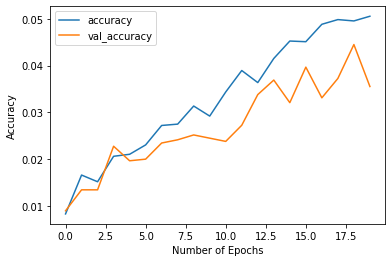

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

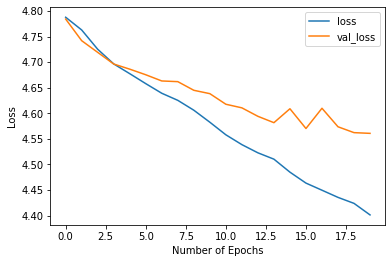

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

#### Conclusion of this model

This model does not perform very well. We get a very low accuracy with the scratch neural networks. But it is better than randomly predicting the model.

#### Vgg16

Here we are using the pre-trained model of vgg-16,where we have suppressed the last three fully connected layers and we have added our layers. This model has 16 layers deep Neural networks as the name suggests.

In [ ]:
def Vgg16_model():
  model_base = VGG16(weights='imagenet',include_top=False,input_shape=(256,256,3))
  x = model_base.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024,activation='relu')(x)
  x = Dense(1024,activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(512,activation='relu')(x)
  pred = Dense(120,activation='softmax')(x)
  model = Model(inputs=model_base.input,outputs=pred)
  for layer in model_base.layers:
    layer.trainable = False

  return model

In [ ]:
model_v = Vgg16_model()

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_v.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_v.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
hist_1 = model_v.fit_generator(generator=train_gen,
                    epochs=50,
                    validation_data=test_gen,
                    callbacks=[early,reduce_lr],
                    steps_per_epoch=step_size_tr,
                    validation_steps=step_size_ts)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
140/140 [==============================] - 2356s 16s/step - loss: 4.8192 - accuracy: 0.0102 - val_loss: 4.6078 - val_accuracy: 0.0159
Epoch 2/50
140/140 [==============================] - 129s 923ms/step - loss: 4.5360 - accuracy: 0.0232 - val_loss: 4.3802 - val_accuracy: 0.0334
Epoch 3/50
140/140 [==============================] - 129s 920ms/step - loss: 4.2892 - accuracy: 0.0355 - val_loss: 4.1401 - val_accuracy: 0.0586
Epoch 4/50
140/140 [==============================] - 128s 916ms/step - loss: 4.0307 - accuracy: 0.0646 - val_loss: 3.8100 - val_accuracy: 0.0924
Epoch 5/50
140/140 [==============================] - 128s 912ms/step - loss: 3.7986 - accuracy: 0.0883 - val_loss: 3.6144 - val_accuracy: 0.1152
Epoch 6/50
140/140 [==============================] - 128s 916ms/step - loss: 3.6190 - accuracy: 0.1124 - val_loss: 3.4859 - val_accuracy: 0.1362
Epoch 7/50
140/140 [==============================] - 128s 916ms/step - loss: 3.4597 - accuracy: 0.1408 - val_loss: 3.4948 - 

Text(0, 0.5, 'Accuracy')

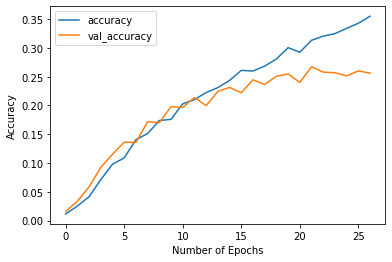

In [ ]:
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

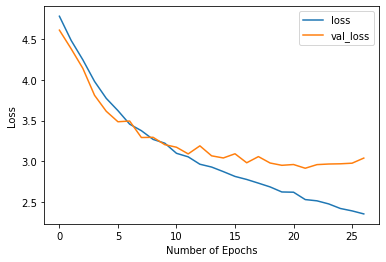

In [ ]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

**Conclusion of this model**

From this model we can say that the model is not giving very good output. As we can see from the results and the graph that the val_loss starts increasing after a certain interval of time. This indicates 'overfitting'. 
Also the accuracy of this model is not very high.

### Xception Model

This is another pre-trained model,that performs well wil image datasets.

In [ ]:
def Xception_model():
  base_model = Xception(weights='imagenet',include_top=False,input_shape=(256,256,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  X = Dense(512,activation='relu')(x)
  x = Dense(512,activation='relu')(x)
  x = Dropout(0.5)(x)
  pred = Dense(120,activation='softmax')(x)
  model = Model(inputs=base_model.input,outputs=pred)

  for layer in base_model.layers:
    layer.trainable = False
  return model

In [ ]:
model_x = Xception_model()

In [ ]:
model_x.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
model_x.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist_2 = model_x.fit_generator(generator=train_gen,
                    epochs=50,
                    validation_data=test_gen,
                    steps_per_epoch=step_size_tr,
                    validation_steps=step_size_ts,
                    callbacks=[early])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
140/140 [==============================] - 134s 916ms/step - loss: 2.9099 - accuracy: 0.3890 - val_loss: 0.6422 - val_accuracy: 0.8100
Epoch 2/50
140/140 [==============================] - 126s 898ms/step - loss: 0.8150 - accuracy: 0.7676 - val_loss: 0.5969 - val_accuracy: 0.8121
Epoch 3/50
140/140 [==============================] - 125s 892ms/step - loss: 0.7393 - accuracy: 0.7866 - val_loss: 0.5772 - val_accuracy: 0.8193
Epoch 4/50
140/140 [==============================] - 124s 887ms/step - loss: 0.6251 - accuracy: 0.8152 - val_loss: 0.5865 - val_accuracy: 0.8214
Epoch 5/50
140/140 [==============================] - 128s 917ms/step - loss: 0.6319 - accuracy: 0.8129 - val_loss: 0.6012 - val_accuracy: 0.8134
Epoch 6/50
140/140 [==============================] - 128s 916ms/step - loss: 0.5590 - accuracy: 0.8217 - val_loss: 0.5938 - val_accuracy: 0.8245
Epoch 7/50
140/140 [==============================] - 124s 888ms/step - loss: 0.5250 - accuracy: 0.8392 - val_loss: 0.6099 -

Text(0, 0.5, 'Accuracy')

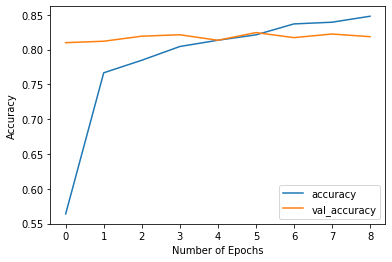

In [ ]:
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

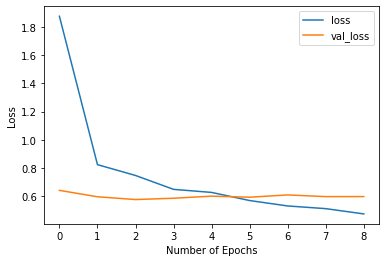

In [ ]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

**Conclusion of Xception model**

This model performs pretty good. But at the end we see there is a slight increase in value loss and hence value accuracy slightly decreases at the end. 
We get training accuracy of 85% and a testing accuracy of 81% which indicates that is is more or less a good model.

**InceptionV3 pre-trained model**

Inception v3 is a CNN used mainly for image and object detection.

In [ ]:
def InceptionV3_model():
  model_base = InceptionV3(weights='imagenet',input_shape=(256,256,3),include_top=False)
  x = model_base.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512,activation='relu')(x)
  pred = Dense(120,activation='softmax')(x)
  model = Model(inputs=model_base.input,outputs=pred)
  for layer in model_base.layers:
    layer.trainable = False
  return model

In [ ]:
model_i = InceptionV3_model()

In [ ]:
model_i.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_i.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
hist = model_i.fit_generator(generator=train_gen,
                             steps_per_epoch=step_size_tr,
                             validation_data=train_gen,
                             validation_steps=step_size_ts,
                             epochs=50,callbacks=[early,reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
140/140 [==============================] - 185s 1s/step - loss: 4.5725 - accuracy: 0.0900 - val_loss: 3.2475 - val_accuracy: 0.5576
Epoch 2/50
140/140 [==============================] - 148s 1s/step - loss: 2.8697 - accuracy: 0.5958 - val_loss: 1.7751 - val_accuracy: 0.7324
Epoch 3/50
140/140 [==============================] - 148s 1s/step - loss: 1.5642 - accuracy: 0.7667 - val_loss: 1.1065 - val_accuracy: 0.7941
Epoch 4/50
140/140 [==============================] - 148s 1s/step - loss: 1.0166 - accuracy: 0.7991 - val_loss: 0.8788 - val_accuracy: 0.8045
Epoch 5/50
140/140 [==============================] - 148s 1s/step - loss: 0.8181 - accuracy: 0.8181 - val_loss: 0.7238 - val_accuracy: 0.8279
Epoch 6/50
140/140 [==============================] - 146s 1s/step - loss: 0.7145 - accuracy: 0.8321 - val_loss: 0.6775 - val_accuracy: 0.8266
Epoch 7/50
140/140 [==============================] - 146s 1s/step - loss: 0.6411 - accuracy: 0.8338 - val_loss: 0.5842 - val_accuracy: 0.8486

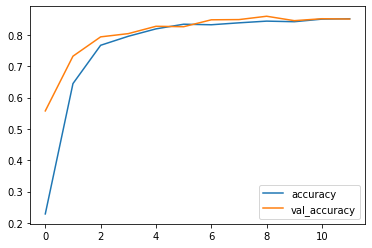

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
         

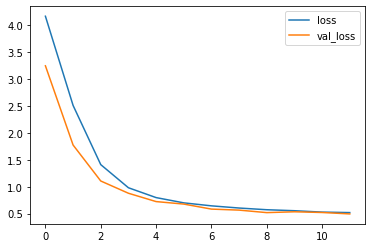

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])

### Conclusion

**InceptionV3** is the best model.In this case the training and testing accuracy are also nearly the same. So this is our final model.
We get a training accuracy of 85.09% and testing accuracy of 85.10%. The model learns pretty well.

In [ ]:
f_model = model_i.save('goodmodel.h5')   # saving our final model